<h1> Stage2 - place clusters completely random into grid </h1>

Run same code as in stage2_csimplenetwork_correct but place clusters completely random in 5x5 field.

In [1]:
import myfunctions as mf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time

In [2]:
# load data
rootfile = uproot.open("./stage2_clusters.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clustersNxN, coord, ind_del = mf.form_cluster(xMC, yMC, EMC, random=True)

This took  153.92989110946655 s


In [4]:
print("Useable clusters: ", len(clustersNxN))
print("Deleted clusters: ", len(ind_del))

Useable clusters:  753956
Deleted clusters:  54


As 50 compared to 0.7 M is rather small, I'll still use 5x5 clusters.

In [5]:
clusters = clustersNxN.reshape((clustersNxN.shape[0], 25))
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

In [6]:
# standardize input
clusters_t = mf.standardscore(clusters_t)
clusters_v = mf.standardscore(clusters_v)

<h2> The network </h2>

This will be the basic network for stage 2. Do not use Layer Normalization as this makes the NN loose the information of total energy!

In [7]:
model = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 9

Check if GPU is running...

In [8]:
try:
    tf.debugging.set_log_device_placement(True)
    print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
except:
   pass 

GPU name:  []
Num GPUs Available:  0


In [9]:
a = time.time()
fit_hist = model.fit(clusters_t, training, batch_size=64, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
8482/8482 [==============================] - 8s 852us/step - loss: 531.7137 - val_loss: 29.1165
Epoch 2/200
8482/8482 [==============================] - 7s 838us/step - loss: 18.8964 - val_loss: 14.0620
Epoch 3/200
8482/8482 [==============================] - 7s 839us/step - loss: 13.3785 - val_loss: 12.0866
Epoch 4/200
8482/8482 [==============================] - 7s 839us/step - loss: 12.0827 - val_loss: 11.2239
Epoch 5/200
8482/8482 [==============================] - 7s 839us/step - loss: 11.4053 - val_loss: 10.6995
Epoch 6/200
8482/8482 [==============================] - 7s 839us/step - loss: 10.9679 - val_loss: 10.3547
Epoch 7/200
8482/8482 [==============================] - 7s 840us/step - loss: 10.6572 - val_loss: 10.0662
Epoch 8/200
8482/8482 [==============================] - 7s 835us/step - loss: 10.4283 - val_loss: 9.8949
Epoch 9/200
8482/8482 [==============================] - 7s 852us/step - loss: 10.2629 - val_loss: 9.7345
Epoch 10/200
8482/8482 [==============

Epoch 155/200
8482/8482 [==============================] - 7s 835us/step - loss: 9.1124 - val_loss: 8.7781
Epoch 156/200
8482/8482 [==============================] - 7s 838us/step - loss: 9.1144 - val_loss: 8.7510
Epoch 157/200
8482/8482 [==============================] - 7s 837us/step - loss: 9.1066 - val_loss: 8.7483
Epoch 158/200
8482/8482 [==============================] - 7s 838us/step - loss: 9.1055 - val_loss: 8.7955
Epoch 159/200
8482/8482 [==============================] - 7s 839us/step - loss: 9.1053 - val_loss: 8.7493
Epoch 160/200
8482/8482 [==============================] - 7s 836us/step - loss: 9.1014 - val_loss: 8.7878
Epoch 161/200
8482/8482 [==============================] - 7s 838us/step - loss: 9.0975 - val_loss: 8.8069
Epoch 162/200
8482/8482 [==============================] - 7s 835us/step - loss: 9.0960 - val_loss: 8.7414
Epoch 163/200
8482/8482 [==============================] - 7s 840us/step - loss: 9.0957 - val_loss: 8.8239
Epoch 164/200
8482/8482 [============

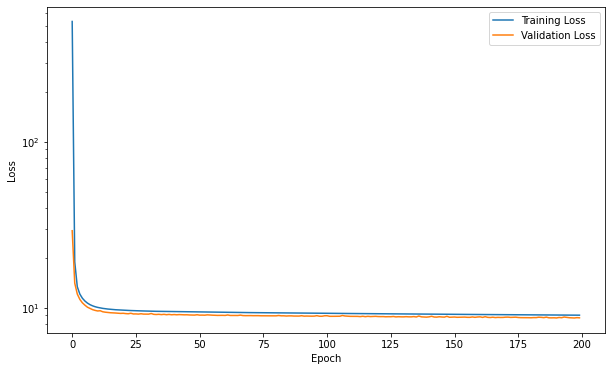

In [10]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [11]:
output = model.predict(clusters_v)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

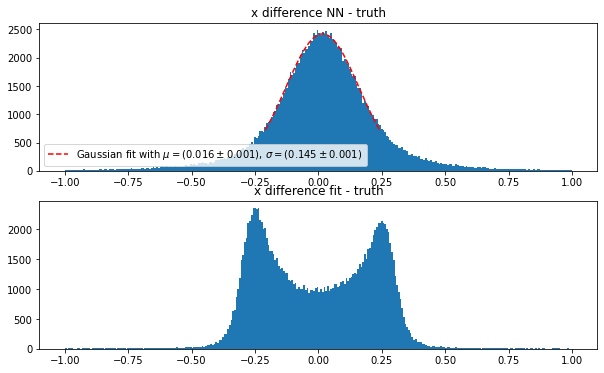

In [17]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", fit=True)

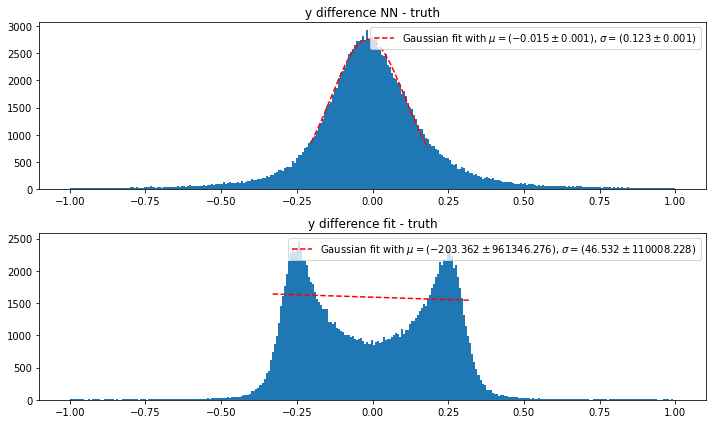

(array([-1.48432133e-02,  1.23392369e-01,  8.52106493e+02]),
 array([9.15896186e-04, 1.21727950e-03, 6.75682488e+00]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [13]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

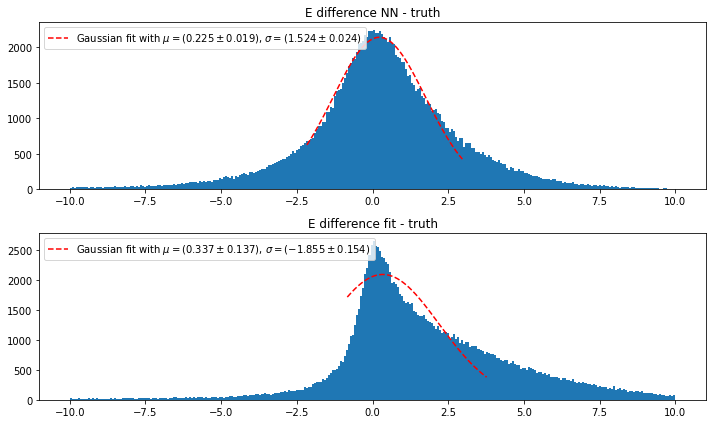

(array([2.25161596e-01, 1.52355793e+00, 8.17347757e+03]),
 array([1.85707410e-02, 2.35271785e-02, 1.02576979e+02]),
 array([ 3.36691567e-01, -1.85509098e+00,  9.70799030e+03]),
 array([1.37209754e-01, 1.54373648e-01, 7.36863988e+02]))

In [14]:
mf.histo_output(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-10,10), fit=True)

relative $E$ difference...

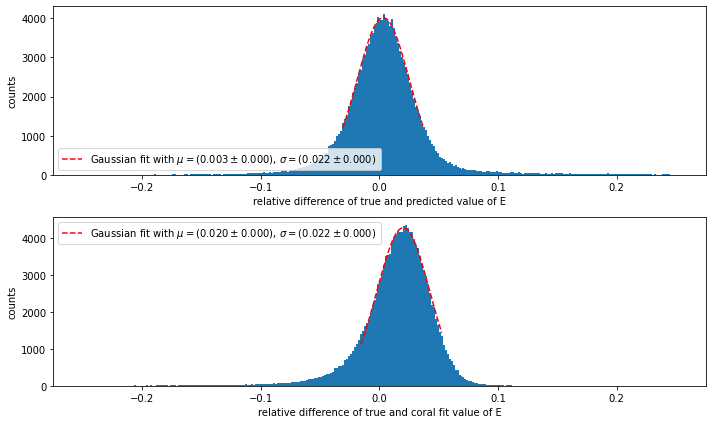

In [15]:
E_bad = mf.histo_output_rel(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-0.25,0.25), fit=True)

In [16]:
keras.models.save_model(model, 'stage2model_corr_standardization_randomzeros')

INFO:tensorflow:Assets written to: stage2model_corr_standardization_randomzeros/assets


<h2> Summary </h2>

This notebook investigated if placing the ecal energy clusters completely random in the 5x5 grid makes a difference on the performance of the network. 

| (x/y/rel E) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| nearly random (standard) |0.021 / 0.058 / 0.005 | 0.123 / 0.125 / 0.022|
| completely random (new) | 0.016 / 0.015 / 0.003 | 0.145 / 0.123 / 0.022 |

One can see that the mean got better (as expected) as every bias on the position of the network is removed. The width sigma stays the same. So placing the clusters completely random doesn't help with the resolution but improves the precision. 